<a href="https://colab.research.google.com/github/boongtol1/2025_BDAP_TP/blob/main/bit_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 1. 필요한 라이브러리 가져오기
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [8]:
# 빗썸에서 캔들 데이터를 가져오는 함수

def fetch_bithumb_candles(pair: str = 'BTC_KRW', interval: str = '1h') -> pd.DataFrame:
    """
    Bithumb 공개 API에서 지정된 종목(pair)과 차트 간격(interval) 캔들 데이터를 가져와
    pandas DataFrame으로 반환합니다.
    """
    url = f'https://api.bithumb.com/public/candlestick/{pair}/{interval}'
    resp = requests.get(url)
    resp.raise_for_status()

    result = resp.json()
    if result.get('status') != '0000':
        raise RuntimeError(f"API error, status: {result.get('status')}")

    # data 필드에 [timestamp, open, close, high, low, volume] 리스트가 들어있음
    candles = result['data']

    # API가 최신순으로 반환하는 경우 시간순으로 뒤집기
    candles.reverse()

    # DataFrame 생성
    df = pd.DataFrame(candles, columns=[
        'timestamp',  # UNIX 시간(ms)
        'open',       # 시가
        'close',      # 종가
        'high',       # 고가
        'low',        # 저가
        'volume'      # 거래량
    ])

    # timestamp를 datetime으로 변환 (단위 ms -> 초 단위라면 unit='s' 로 변경)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    return df


In [9]:
# 가져온 캔들 데이터 전처리 함수

def preprocess_candles(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) 인덱스를 KST(Asia/Seoul) datetime으로 설정
    2) 결측치는 직전 값으로 보간(Forward Fill)
    3) 1시간 후 종가(target) 컬럼 생성
    """
    df = df.copy()

    # 1) 인덱스를 UTC로 간주하고 KST로 변환
    #    (만약 df.index가 naive datetime이라면 UTC로 로컬라이즈 후 변환)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('UTC').tz_convert('Asia/Seoul')

    # 2) 결측치 처리: 직전 값 보간법
    df.fillna(method='ffill', inplace=True)

    # 3) 레이블 생성: 1시간 뒤 종가
    #    1시간 간격이므로 shift(-1)을 사용
    df['target'] = df['close'].shift(+1)

    return df



In [10]:
# 모델 학습 및 예측을 위한 데이터 준비, 모델 학습 및 예측 함수
def split_timeseries(df: pd.DataFrame, train_ratio=0.7, val_ratio=0.15):
    """시계열 데이터를 train(훈련 70%)/val(검증 15%)/테스트 15%로 분할"""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

def create_sequences(features: np.ndarray, targets: np.ndarray, seq_length: int):
    """LSTM 입력을 위한 시퀀스 데이터 생성"""
    X, y = [], []
    for i in range(len(features) - seq_length - 1):
        seq_features = features[i:i+seq_length]

        # 방향성 특징 추가 (마지막 3시간 종가 평균 변화율)
        price_changes = seq_features[-3:, 3]  # 3번 인덱스가 'close' 피처
        direction_feature = np.mean(np.diff(price_changes))

        # 특징 벡터에 방향성 특징 추가
        extended_seq = np.vstack([seq_features, [direction_feature]*features.shape[1]])
        X.append(extended_seq)
        y.append(targets[i + seq_length])

    return np.array(X), np.array(y)

def prepare_data():
    """데이터 준비 파이프라인"""
    df = fetch_bithumb_candles('BTC_KRW', '1h')
    df = preprocess_candles(df)

    numeric_cols = ['open','high','low','close','volume','target']
    df[numeric_cols] = df[numeric_cols].apply(
        pd.to_numeric, errors='coerce'
    ).fillna(method='ffill').fillna(method='bfill')

    for window in [1, 3, 6]:
        df[f'return_{window}h'] = df['close'].pct_change(window)

    df['SMA_3'] = df['close'].rolling(3).mean()
    df['EMA_3'] = df['close'].ewm(span=3, adjust=False).mean()
    df.dropna(inplace=True)

    return split_timeseries(df)

def di_mse(y_true, y_pred):
    import tensorflow.keras.backend as K
    direction_loss = K.square(K.sign(y_true - y_pred) - 1)
    value_loss = K.square(y_true - y_pred)
    return K.mean(value_loss + 0.5 * direction_loss)

def train_and_predict(df_train, df_val, df_test, seq_length=24):
    """모델 학습 및 예측 수행"""
    feature_cols = ['open','high','low','close','volume',
                   'SMA_3','EMA_3','return_1h','return_3h','return_6h']

    # 스케일링
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(df_train[feature_cols])
    X_val = scaler_X.transform(df_val[feature_cols])
    X_test = scaler_X.transform(df_test[feature_cols])

    y_train = scaler_y.fit_transform(df_train[['target']]).flatten()
    y_val = scaler_y.transform(df_val[['target']]).flatten()
    y_test = scaler_y.transform(df_test[['target']]).flatten()

    # 시퀀스 생성
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    # 모델 구성 및 학습
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True),
                     input_shape=(seq_length+1, len(feature_cols))),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=di_mse,
        metrics=['mae', 'mse']
    )

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=200,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    # 예측 수행
    y_pred = scaler_y.inverse_transform(
        model.predict(X_test_seq).flatten().reshape(-1,1)
    )
    y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))

    return y_true.flatten(), y_pred.flatten(), model


In [11]:
# 모델 학습 및 예측 결과를 이용한 백테스트 함수

def run_backtest(y_true, y_pred, df_test, seq_length=24):
    """백테스팅 실행"""
    # 실제 종가 데이터 슬라이싱
    close_prices = df_test['close'].values[seq_length+1:]

    # 방향성 정확도 계산
    direction_true = np.diff(y_true) > 0
    direction_pred = np.diff(y_pred) > 0
    dir_acc = np.mean(direction_true == direction_pred) * 100

    # 백테스팅 신호 생성
    signals = np.zeros_like(y_pred)
    signals[1:] = np.where(y_pred[1:] > y_pred[:-1], 1, -1)

    # 수익률 계산
    returns = np.diff(close_prices) / close_prices[:-1]
    strategy_returns = signals[1:] * returns

    # 누적 수익률
    cumulative_returns = np.cumprod(1 + strategy_returns) - 1

    return {
        'true_prices': close_prices,
        'pred_prices': y_pred,
        'signals': signals,
        'returns': cumulative_returns,
        'direction_accuracy': dir_acc
    }


<ipython-input-9-0dbc74cfc018>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-10-1b39e853bbf7>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 1.1081 - mae: 0.2426 - mse: 0.1434 - val_loss: 0.7564 - val_mae: 0.0338 - val_mse: 0.0022
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 1.0349 - mae: 0.0751 - mse: 0.0101 - val_loss: 1.0989 - val_mae: 0.0309 - val_mse: 0.0022
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 1.0373 - mae: 0.0625 - mse: 0.0071 - val_loss: 0.9002 - val_mae: 0.0286 - val_mse: 0.0024
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.9822 - mae: 0.0538 - mse: 0.0053 - val_loss: 1.0161 - val_mae: 0.0272 - val_mse: 0.0023
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 1.0528 - mae: 0.0508 - mse: 0.0049 - val_loss: 1.6598 - val_mae: 0.0350 - val_mse: 0.0023
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 1.0187 - mae: 0.0532 - mse: 0.0052 - val_loss: 0.4446 - val_mae: 0.0314 - val_mse: 0.0026
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.9868 - mae: 0.0468 - mse:

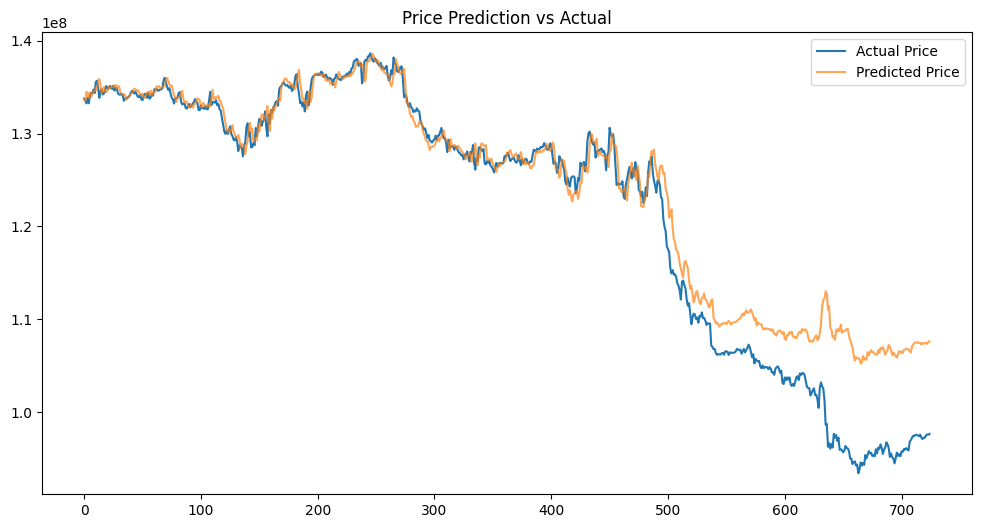

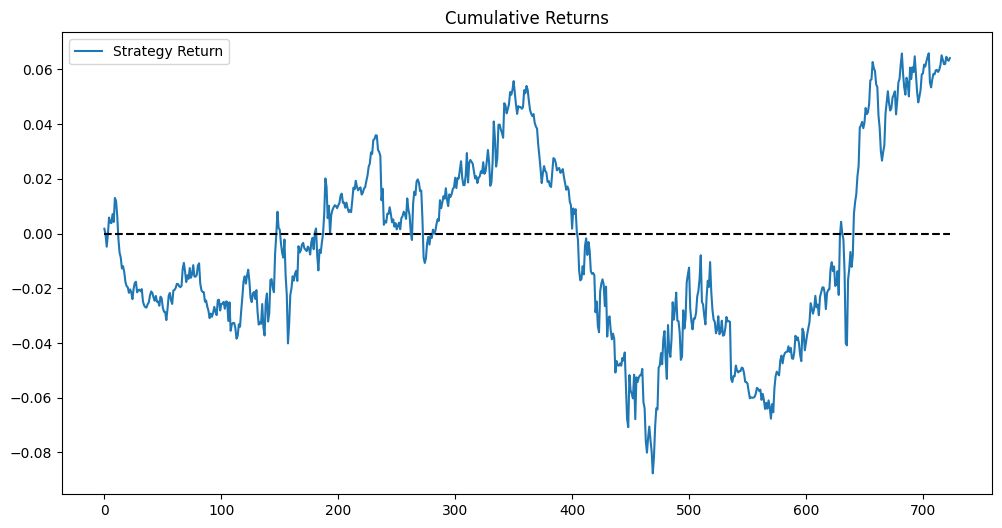

In [12]:
# 메인 실행: 1.데이터 준비, 2.모델 학습 및 예측, 3.백테스팅 실행, 4.결과 출력

if __name__ == '__main__':
    # 1. 데이터 준비
    df_train, df_val, df_test = prepare_data()

    # 2. 모델 학습 및 예측
    y_true, y_pred, model = train_and_predict(df_train, df_val, df_test)

    # 3. 백테스팅 실행
    bt_results = run_backtest(y_true, y_pred, df_test)

    # 4. 결과 출력
    print(f"Directional Accuracy: {bt_results['direction_accuracy']:.2f}%")
    print(f"Final Cumulative Return: {bt_results['returns'][-1]*100:.2f}%")

    # 결과 시각화
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))
    plt.plot(bt_results['true_prices'], label='Actual Price')
    plt.plot(bt_results['pred_prices'], label='Predicted Price', alpha=0.7)
    plt.title('Price Prediction vs Actual')
    plt.legend()
    plt.show()

    # 신호와 수익률 시각화
    plt.figure(figsize=(12,6))
    plt.plot(bt_results['returns'], label='Strategy Return')
    plt.plot(np.zeros_like(bt_results['returns']), 'k--')
    plt.title('Cumulative Returns')
    plt.legend()
    plt.show()

